### Theory 3:
##### What is  the correlation between ratings and sales?
* Are movies with higher ratings generating more net profit than less rated ones? 


In [1]:
import requests
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
from scipy.stats import linregress
import json
from config import api_key
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

url = "http://www.omdbapi.com/?t="
api_key = "&apikey=" + api_key

movies_path = "mcu_domestic_global_box_office.csv"
movies_df = pd.read_csv(movies_path)
movies_df.head()


,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office
0,5/2/08,Iron Man,"$186,000,000","$102,118,668","$318,604,126","$585,171,547"
1,6/13/08,The Incredible Hulk,"$137,500,000","$55,414,050","$134,806,913","$265,573,859"
2,5/7/10,Iron Man 2,"$170,000,000","$128,122,480","$312,433,331","$621,156,389"
3,5/6/11,Thor,"$150,000,000","$65,723,338","$181,030,624","$449,326,618"
4,7/22/11,Captain America: The First Avenger,"$140,000,000","$65,058,524","$176,654,505","$370,569,776"


##### Getting the ratings using the API

In [2]:
imdb_rating = []
rotten_tomatoes_rating = []
metacritic_rating = []
imdb_rating_float = 0.0


for index in range(len(movies_df)):
    movie_name = movies_df.iloc[index]['Movie']
    response = requests.get(url + movie_name + api_key)
    data = response.json()
    try:
        imdb_rating_float = data['imdbRating'] 
        imdb_rating.append(float(imdb_rating_float) * 10)
        rotten_tomatoes_rating.append(data['Ratings'][1]['Value'])
        metacritic_rating.append(data['Ratings'][2]['Value'])
    
    except:
        print (response)
        print(data)
        print("No data found for movie: " + movie_name)


In [3]:
movies_df['Rotten_Tomatoes_Rating_%'] = rotten_tomatoes_rating
movies_df['IMDB_Rating'] = imdb_rating
movies_df['Metacritic_Rating'] = metacritic_rating
movies_df.head()

,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating
0,5/2/08,Iron Man,"$186,000,000","$102,118,668","$318,604,126","$585,171,547",94%,79.0,79/100
1,6/13/08,The Incredible Hulk,"$137,500,000","$55,414,050","$134,806,913","$265,573,859",67%,67.0,61/100
2,5/7/10,Iron Man 2,"$170,000,000","$128,122,480","$312,433,331","$621,156,389",72%,70.0,57/100
3,5/6/11,Thor,"$150,000,000","$65,723,338","$181,030,624","$449,326,618",77%,70.0,57/100
4,7/22/11,Captain America: The First Avenger,"$140,000,000","$65,058,524","$176,654,505","$370,569,776",80%,69.0,66/100


##### Data Clean-up 

In [4]:

movies_df['Domestic Box Office']= movies_df['Domestic Box Office'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Worldwide Box Office']= movies_df['Worldwide Box Office'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Production Budget']= movies_df['Production Budget'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Opening Weekend']= movies_df['Opening Weekend'].replace('[$,.]',"",regex=True).astype(float)
movies_df['Net_Profit'] = movies_df['Domestic Box Office'] - movies_df['Production Budget']

movies_df['Release Date'] = pd.to_datetime(movies_df['Release Date'])

movies_df['Rotten_Tomatoes_Rating_%'] = movies_df['Rotten_Tomatoes_Rating_%'].str.replace('%','').astype(float)
movies_df['Metacritic_Rating'] = movies_df['Metacritic_Rating'].str.replace('/100','').astype(float)

movies_df.head()


,Release Date,Movie,Production Budget,Opening Weekend,Domestic Box Office,Worldwide Box Office,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating,Net_Profit
0,2008-05-02,Iron Man,186000000.0,102118668.0,318604126.0,585171547.0,94.0,79.0,79.0,132604126.0
1,2008-06-13,The Incredible Hulk,137500000.0,55414050.0,134806913.0,265573859.0,67.0,67.0,61.0,-2693087.0
2,2010-05-07,Iron Man 2,170000000.0,128122480.0,312433331.0,621156389.0,72.0,70.0,57.0,142433331.0
3,2011-05-06,Thor,150000000.0,65723338.0,181030624.0,449326618.0,77.0,70.0,57.0,31030624.0
4,2011-07-22,Captain America: The First Avenger,140000000.0,65058524.0,176654505.0,370569776.0,80.0,69.0,66.0,36654505.0


In [5]:
movies_df = movies_df.filter(["Release Date",'Movie','Net_Profit','Rotten_Tomatoes_Rating_%','IMDB_Rating','Metacritic_Rating'], axis=1)
movies_df.head()

,Release Date,Movie,Net_Profit,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating
0,2008-05-02,Iron Man,132604126.0,94.0,79.0,79.0
1,2008-06-13,The Incredible Hulk,-2693087.0,67.0,67.0,61.0
2,2010-05-07,Iron Man 2,142433331.0,72.0,70.0,57.0
3,2011-05-06,Thor,31030624.0,77.0,70.0,57.0
4,2011-07-22,Captain America: The First Avenger,36654505.0,80.0,69.0,66.0


##### Geeting  the max and min site ratings 

In [6]:
movies_df_new = movies_df.copy()
movies_df_new['Net_Profit'] =  movies_df_new['Net_Profit'].apply(lambda x: '${:,.0f}'.format(x))

max_rotten = movies_df_new["Rotten_Tomatoes_Rating_%"].max()
index = movies_df_new["Rotten_Tomatoes_Rating_%"].idxmax()
movie_name_rotten = movies_df_new.loc[index,:].Movie
movie_net_profit = movies_df_new.loc[index,:].Net_Profit
print ("--Rotten Tomatoes")
print(f"Highest rating -{movie_name_rotten} - {max_rotten}% {movie_net_profit}")

min_rotten = movies_df_new["Rotten_Tomatoes_Rating_%"].min()
index = movies_df_new["Rotten_Tomatoes_Rating_%"].idxmin()
movie_name_rotten = movies_df_new.loc[index,:].Movie
movie_net_profit = movies_df_new.loc[index,:].Net_Profit
print(f"Lowest Rating -{movie_name_rotten} -  {min_rotten}% {movie_net_profit}")
#-----
print("")
print ("--IMDB")


max_imdb = movies_df_new[movies_df_new["IMDB_Rating"] == movies_df_new["IMDB_Rating"].max()]
                             
index_imdb = movies_df_new[movies_df_new["IMDB_Rating"] == movies_df_new["IMDB_Rating"].max()].index

index1 = int(index_imdb[0])
index2 = int(index_imdb[1])

max_imdb_rat = max_imdb.IMDB_Rating[index1]
movie_name_1 = max_imdb.Movie[index1]
movie_net_profit_1 = max_imdb.Net_Profit[index1]

movie_name_2 = max_imdb.Movie[index2]
movie_net_profit_2 = max_imdb.Net_Profit[index2]


index1 = int(index_imdb[0])
index2 = int(index_imdb[1])


print(f"Highest rating -{movie_name_1} - {max_imdb_rat}% {movie_net_profit_1}")
print(f"Highest rating -{movie_name_2} - {max_imdb_rat}% {movie_net_profit_2}")


min_imdb = movies_df_new["IMDB_Rating"].min()
index_low = movies_df_new["IMDB_Rating"].idxmin()

movie_name_imdb_low = movies_df_new.loc[index_low,:].Movie
movie_net_profit_low = movies_df_new.loc[index_low,:].Net_Profit
print(f"Lowest Rating -{movie_name_imdb_low} - {min_imdb}% {movie_net_profit_low}")
#------
print("")
print ("--Metacritic_Rating")
max_rotten = movies_df_new["Metacritic_Rating"].max()
index = movies_df_new["Metacritic_Rating"].idxmax()
movie_name_rotten = movies_df_new.loc[index,:].Movie
movie_net_profit = movies_df_new.loc[index,:].Net_Profit
print(f"Highest rating - {movie_name_rotten} - {max_rotten}% {movie_net_profit}")

min_rotten = movies_df_new["Metacritic_Rating"].min()
index = movies_df_new["Metacritic_Rating"].idxmin()
movie_name_rotten = movies_df_new.loc[index,:].Movie
movie_net_profit = movies_df_new.loc[index,:].Net_Profit
print(f"Lowest Rating - {movie_name_rotten} - {min_rotten}% {movie_net_profit}")


--Rotten Tomatoes
Highest rating -Black Panther - 96.0% $500,059,566
Lowest Rating -Thor: The Dark World -  66.0% $56,362,140

--IMDB
Highest rating -Avengers: Infinity War - 84.0% $378,815,482
Highest rating -Avengers: Endgame - 84.0% $502,373,000
Lowest Rating -The Incredible Hulk - 67.0% $-2,693,087

--Metacritic_Rating
Highest rating - Black Panther - 88.0% $500,059,566
Lowest Rating - Thor: The Dark World - 54.0% $56,362,140


##### Sorting the new Dataframe by Rotten Tomatoes Ratings

In [7]:
movies_df_new = movies_df_new.sort_values('Rotten_Tomatoes_Rating_%', ascending=False)
movies_df_new

,Release Date,Movie,Net_Profit,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating
17,2018-02-16,Black Panther,"$500,059,566",96.0,73.0,88.0
0,2008-05-02,Iron Man,"$132,604,126",94.0,79.0,79.0
21,2019-04-26,Avengers: Endgame,"$502,373,000",94.0,84.0,78.0
16,2017-11-03,Thor: Ragnarok,"$135,058,289",93.0,79.0,74.0
15,2017-07-07,Spider-Man: Homecoming,"$159,201,140",92.0,74.0,73.0
5,2012-05-04,The Avengers,"$398,357,910",91.0,80.0,69.0
9,2014-08-01,Guardians of the Galaxy,"$163,714,112",91.0,80.0,76.0
12,2016-05-06,Captain America: Civil War,"$158,084,349",90.0,78.0,75.0
8,2014-04-04,Captain America: The Winter Soldier,"$89,746,958",90.0,77.0,70.0
13,2016-11-04,Doctor Strange,"$67,641,920",89.0,75.0,72.0


## Movies VS Ratings

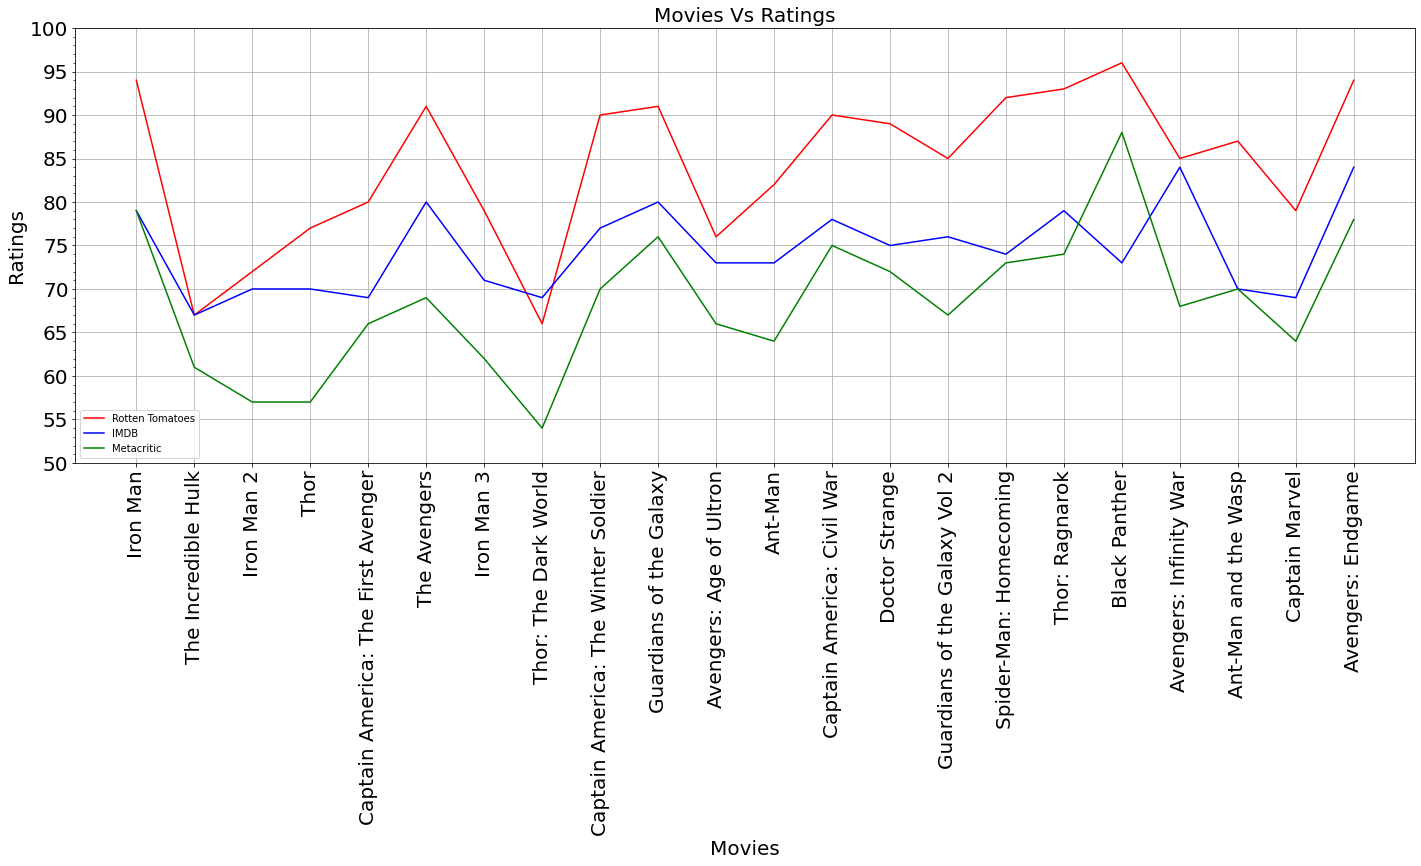

In [8]:

x_axis = movies_df.Movie
fig,ax = plt.subplots(figsize =(24, 8))

points = movies_df['Rotten_Tomatoes_Rating_%']
points2 = movies_df['IMDB_Rating']
points3 = movies_df['Metacritic_Rating']

plt.plot(x_axis, points,color="red", label="Rotten Tomatoes")
plt.plot(x_axis, points2,color="blue", label="IMDB")
plt.plot(x_axis, points3,color="green", label="Metacritic")

plt.ylabel("Ratings", fontsize=20)
plt.xlabel("Movies", fontsize=20)
plt.title(f"Movies Vs Ratings", fontsize=20)
plt.legend()

plt.grid()

plt.ylim(50, 100)

# set up the y-axis to go display numbers by 5 and put minor tick for every 1
ax.yaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_formatter('{x:.0f}')
ax.yaxis.set_minor_locator(MultipleLocator(1))

plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('ratings.png')
plt.show()

## Movies Vs Net Profit

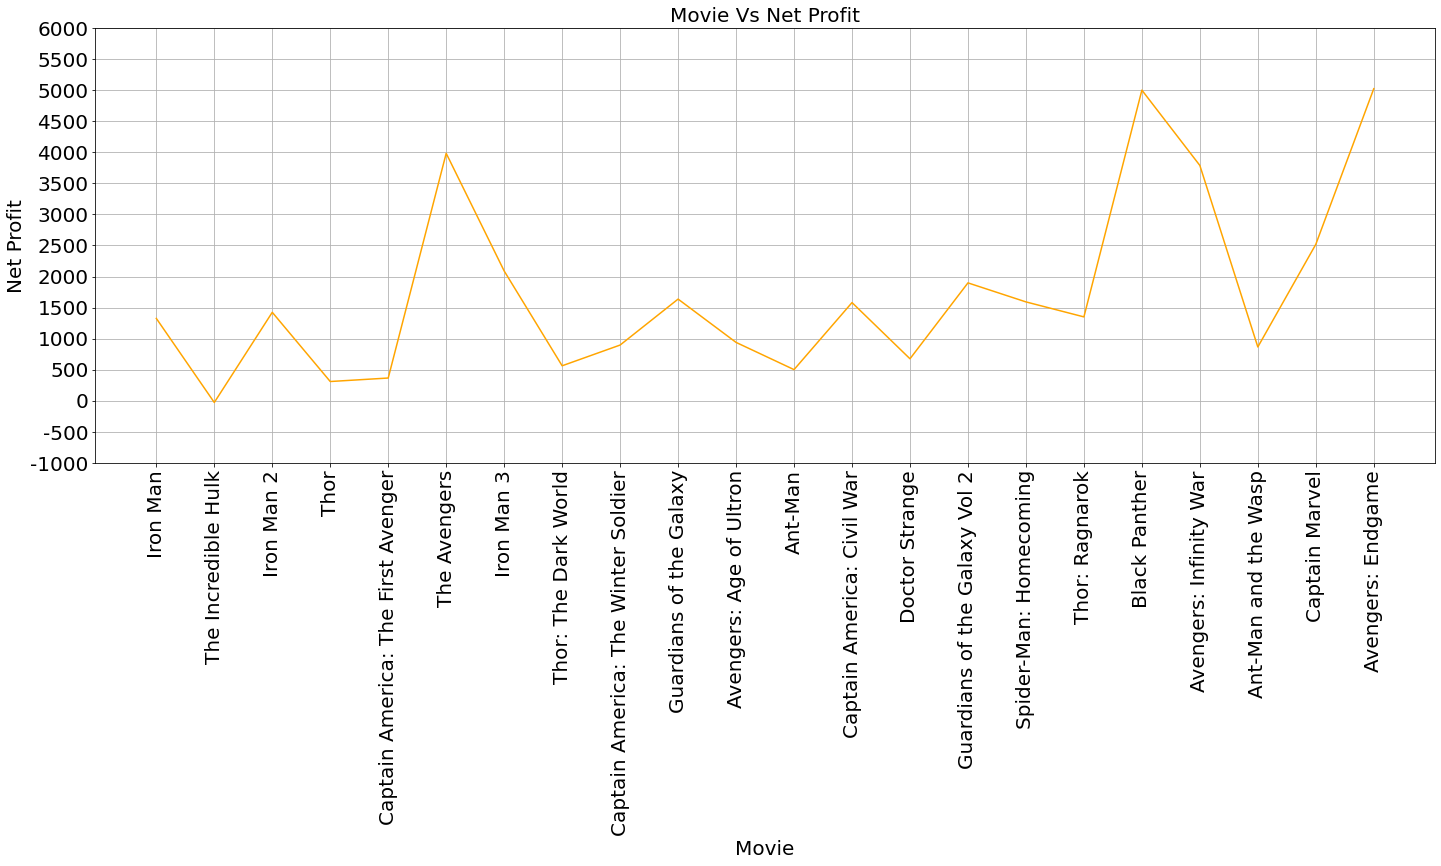

In [9]:
x_axis = movies_df.Movie
fig,ax = plt.subplots(figsize =(24, 8))

points_net = movies_df['Net_Profit']/100000

plt.plot(x_axis, points_net,color="orange", label="Net Profit")

plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("Movie", fontsize=20)
plt.title(f"Movie Vs Net Profit", fontsize=20 )

plt.grid()

plt.ylim(-1000, 6000)

# set up the y-axis to go display numbers by 5 and put minor tick for every 1
ax.yaxis.set_major_locator(MultipleLocator(500))
ax.yaxis.set_major_formatter('{x:.0f}')

plt.xticks(rotation=90,fontsize = 20)
plt.yticks(fontsize = 20)
plt.savefig('fig00.png')
plt.show()

###  Correlation and Regression
* Net Profit vs Rating Sites

The r-value is: 0.52


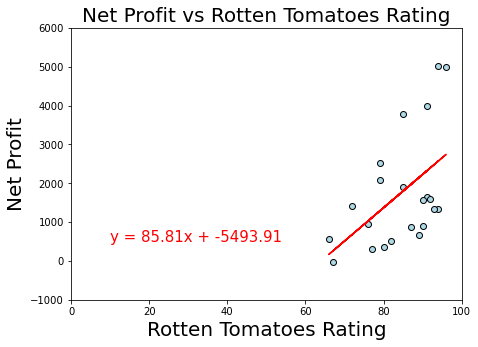

In [10]:
y_axis = movies_df['Net_Profit']/100000

x_axis = movies_df['Rotten_Tomatoes_Rating_%'] 
fig,ax = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")

plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("Rotten Tomatoes Rating", fontsize=20)
plt.title(f"Net Profit vs Rotten Tomatoes Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")

plt.savefig('Fig01.png')
plt.show()


The r-value is: 0.57


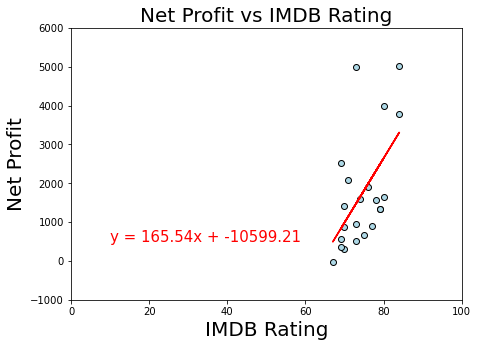

In [11]:
y_axis = movies_df['Net_Profit']/100000
x_axis = movies_df['IMDB_Rating'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("IMDB Rating", fontsize=20)
plt.title(f"Net Profit vs IMDB Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")

plt.savefig('Fig02.png')
plt.show()

The r-value is: 0.54


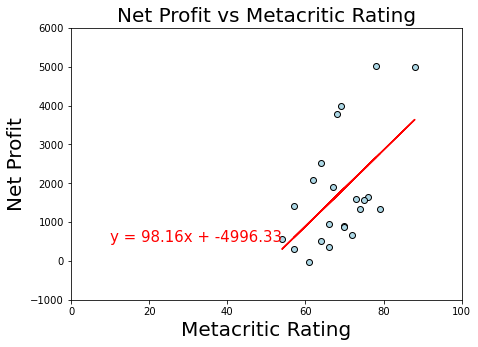

In [12]:
y_axis = movies_df['Net_Profit']/100000
x_axis = movies_df['Metacritic_Rating'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black",alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("Metacritic Rating", fontsize=20)
plt.title(f"Net Profit vs Metacritic Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")
plt.savefig('Fig03.png')
plt.show()

## Checking for Outliers

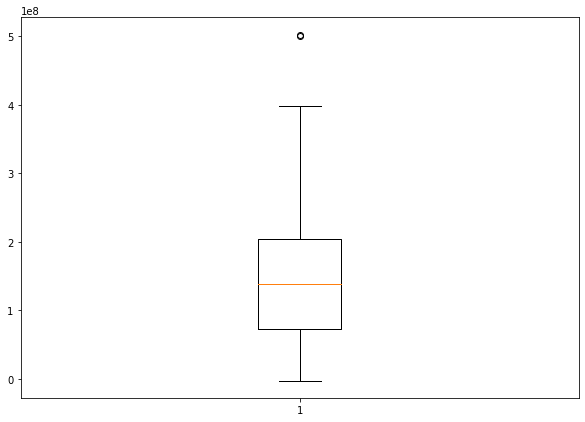

In [13]:
data = movies_df['Net_Profit']
fig = plt.figure(figsize =(10, 7))
plt.boxplot(data)
  

plt.show()

In [14]:
data = movies_df['Net_Profit']
data.quantile([.25,.5,.75])

0.25    7.239362e+07
0.50    1.387458e+08
0.75    2.041975e+08
Name: Net_Profit, dtype: float64

In [15]:
quartiles = data.quantile([.25,.5,.75])
lowerq = quartiles[0.25]
upperq = quartiles[0.75]
iqr = upperq-lowerq

print(f"The lower quartile of Net Profit is: {lowerq}")
print(f"The upper quartile of Net Profit is: {upperq}")
print(f"The interquartile range of Net Profit is: {iqr}")
print(f"The the median of Net Profit is: {quartiles[0.5]} ")

lower_bound = lowerq - (1.5*iqr)
upper_bound = upperq + (1.5*iqr)
print(f"Values below {lower_bound} could be outliers.")
print(f"Values above {upper_bound} could be outliers.")

The lower quartile of Net Profit is: 72393625.0
The upper quartile of Net Profit is: 204197479.25
The interquartile range of Net Profit is: 131803854.25
The the median of Net Profit is: 138745810.0 
Values below -125312156.375 could be outliers.
Values above 401903260.625 could be outliers.


### Removing the Outliers

In [16]:
good_movies_df = movies_df[(movies_df['Net_Profit']<upper_bound) &
                          (movies_df['Net_Profit']>lower_bound)].dropna()

good_movies_df = good_movies_df.reset_index()
good_movies_df.head()

,index,Release Date,Movie,Net_Profit,Rotten_Tomatoes_Rating_%,IMDB_Rating,Metacritic_Rating
0,0,2008-05-02,Iron Man,132604126.0,94.0,79.0,79.0
1,1,2008-06-13,The Incredible Hulk,-2693087.0,67.0,67.0,61.0
2,2,2010-05-07,Iron Man 2,142433331.0,72.0,70.0,57.0
3,3,2011-05-06,Thor,31030624.0,77.0,70.0,57.0
4,4,2011-07-22,Captain America: The First Avenger,36654505.0,80.0,69.0,66.0


### Linear Regression without outliers
* Net Profit vs Rating Sites

The r-value is: 0.37


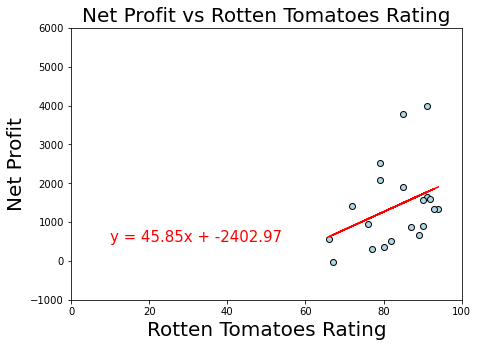

In [17]:
y_axis = good_movies_df['Net_Profit']/100000

x_axis = good_movies_df['Rotten_Tomatoes_Rating_%'] 
fig,ax = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")

plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("Rotten Tomatoes Rating", fontsize=20)
plt.title(f"Net Profit vs Rotten Tomatoes Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")

plt.savefig('Fig04.png')
plt.show()

The r-value is: 0.61


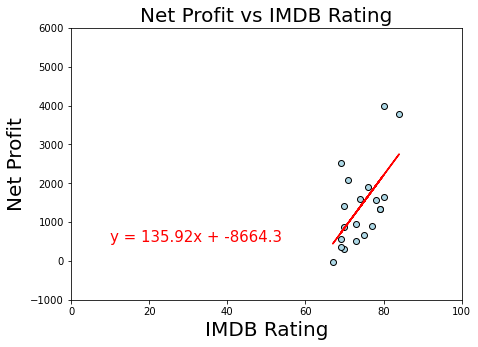

In [18]:
y_axis = good_movies_df['Net_Profit']/100000
x_axis = good_movies_df['IMDB_Rating'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black", alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("IMDB Rating", fontsize=20)
plt.title(f"Net Profit vs IMDB Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")

plt.savefig('Fig05.png')
plt.show()

The r-value is: 0.23


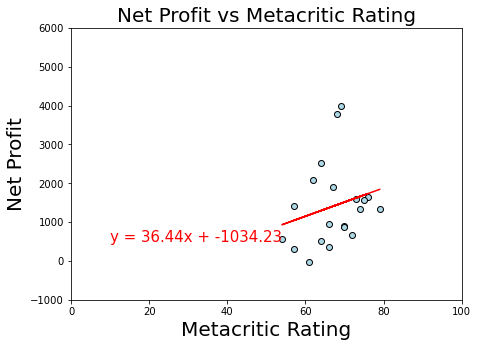

In [19]:
y_axis = good_movies_df['Net_Profit']/100000
x_axis = good_movies_df['Metacritic_Rating'] 
fig = plt.subplots(figsize =(7, 5))
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_axis, y_axis)
regress_values = x_axis * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.plot(x_axis,regress_values,"r-")
plt.annotate(line_eq,(10,500),fontsize=15,color="red")


plt.scatter(x_axis, y_axis, marker="o", facecolors="lightblue", edgecolors="black",alpha=1)
plt.xlim(0, 100)
plt.ylim(-1000, 6000)
plt.ylabel("Net Profit", fontsize=20)
plt.xlabel("Metacritic Rating", fontsize=20)
plt.title(f"Net Profit vs Metacritic Rating", fontsize=20 )
print(f"The r-value is: {round(rvalue,2)}")
plt.savefig('Fig06.png')
plt.show()